In [2]:
# create presentation (ignore error msg)
!jupyter nbconvert presentation.ipynb --to slides --post serve

[NbConvertApp] Converting notebook presentation.ipynb to slides
[NbConvertApp] Writing 718213 bytes to presentation.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\ProgramData\Anaconda3\lib\site-packages\jupyter_core\application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 340, in start
    self.convert_notebooks()
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 510, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "C:\ProgramDa

In [11]:
import time
import torch.optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models
from datasets.dataset import CUBDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
from numpy import unravel_index
from collections import Counter, defaultdict

# Learning Multi-Attention Convolutional Neural Network for Fine-GrainedImage Recognition

In [12]:
N_parts = 5

In [13]:
trainset = CUBDataset()
trainloader = DataLoader(dataset=trainset, batch_size=10, shuffle=True)
testset = CUBDataset(is_test = True)
testloader = DataLoader(dataset=testset, batch_size=10, shuffle=True)

# Preprocessing

### Normalization

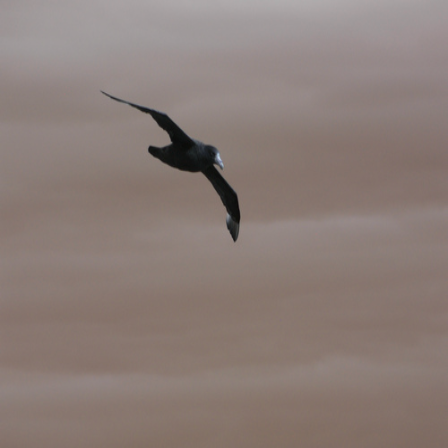

In [10]:
# TODO add to preprocessing
base_img , label = trainset[100]
Image.fromarray(base_img.transpose(1,2,0).astype(np.uint8), 'RGB')

torch.Size([1, 3, 448, 448])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


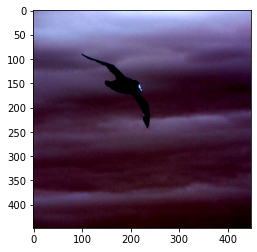

In [11]:
img = transforms.ToTensor()(base_img)
img = img.permute(1,2,0)
img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
img = img.unsqueeze(0)
print(img.shape)
plt.imshow(img.squeeze(0).permute(1,2,0))

# channel grouping

# Channels

In [14]:
vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)

Using cache found in C:\Users\Vincent/.cache\torch\hub\pytorch_vision_v0.9.0


In [16]:
vgg19.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

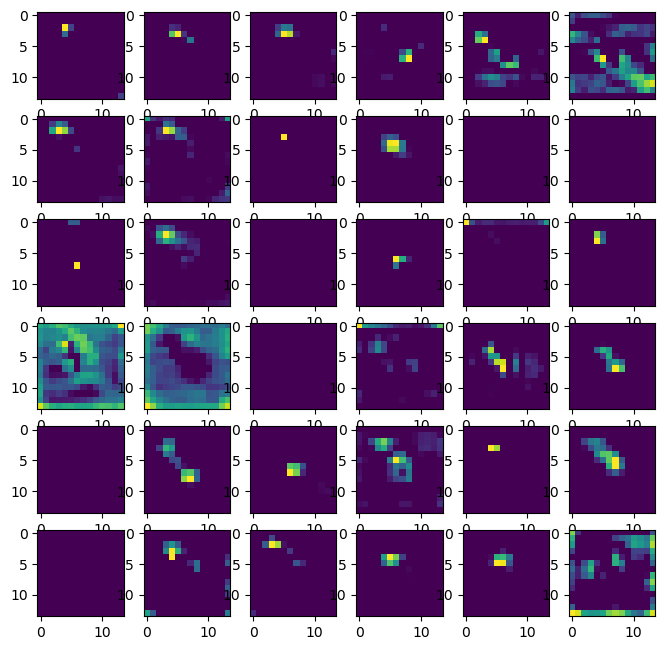

In [14]:
f, axarr = plt.subplots(6,6, figsize=(8,8), dpi= 100)
counter = 0

for i, _ in enumerate(axarr):
    for j, _ in enumerate(axarr[i]):
        axarr[i,j].imshow(patters[counter])
        counter += 1

### Position vector

$[t^1_x, t^1_y, t^2_x, t^2_y, ... t^Ω_x, t^Ω_y]$

In [12]:
channels = vgg19.features(img)

coordinates = list()
for channel in channels.detach().numpy()[0]:
    coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]

t_flat = [point for coordinate in coordinates for point in coordinate]
t_flat = torch.FloatTensor(t_flat)

### Weight vector

$d_i(X) =f_i(W∗X)$

In [8]:
class Net(nn.Module):
    """
    Part NN
    FC Layers which produce a weight vector d_i(X) from [d_1 .. d_c], where c is the length of feature channels.
    Takes as input convolutional features which gets represented as positional vectors t.
    """
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 512)
    
    def forward(self, t):
        """
        t = position vector
        d = weight vector
        """
        d = self.fc1(t)
        d = self.fc2(d)
        return d

### Attention Maps

$M_i(X) = sigmoid(\sum_{i=1}^cd_{ji}[W∗X]_j)$

In [6]:
def attention_map(feature_channels, d):
    """
    i = n-th Part
    j = 1..c
    Mi(X) = sigmoid(∑dji[W∗X]j)
    W∗X = j-th feature channel
    dji = j-th weight vector
    """
    M = 0
    for i in range(feature_channels.size(0)):
        M += d[i] * feature_channels[i]
    M = torch.sigmoid(M)
    return M

### Clustering loss

$L_{cng}(M_i) =Dis(M_i) +λDiv(M_i)$

$Dis(M_i) =∑_{(x,y)∈M_i}m_i(x, y)[||x−t_x||^2+||y−t_y||^2]$

$Div(M_i) =∑_{(x,y)∈M_i}m_i(x, y)[max_{k!=i}m_k(x, y)−mrg]$

$weights = 2$

$margin = 0.02$

In [7]:
def loss_CNG(M, t):
    """
    Input are the coordinates of the position vector "t" and all attention maps of one image "M".
    Lcng(Mi) =Dis(Mi) +λDiv(Mi)
    The λ in Eqn. (7) and mrg in Eqn. (9) are empirically set to 2 and 0.02.
    """
    weight = 2
    margin = .02
    loss = list()
    
    def distance(mi, ix, iy, i, t):
        """Dis(Mi) =∑(x,y)∈Mi(mi(x, y)[||x−tx||2+||y−ty||2])"""
        tx, ty = list(zip(*t))
        tx, ty = np.array(tx), np.array(ty)
        euclidean_norm = lambda x: np.sqrt(sum(elm**2 for elm in x))
        return mi[iy,ix] * (euclidean_norm(ix - tx)** 2 + euclidean_norm(iy - ty)**2)

    def diversity(M, i, ix, iy, mrg):
        """Div(Mi) =∑(x,y)∈Mi(mi(x, y)[max(k/=im)_k(x, y)−mrg])"""
        return M[i][iy,ix] * (max([M[k][iy,ix] for k in range(len(M)) if k != i]) - mrg)
    
    for i, mi in enumerate(M):
        dis = 0
        div = 0
        for iy in range(mi.size(0)):
            for ix in range(mi.size(1)):
                dis += distance(mi, ix, iy, i, t)
                div += diversity(M, i, ix, iy, margin)
        loss.append(dis + weight * div)

    return loss

In [13]:
threshold = 150
patters = [channels[0,i].detach().numpy() for i in range(channels.size(1))]
patters2 = [patter for patter in patters if np.argmax(patter) > threshold]
print(len(patters2), patters2[0].shape)

18 (14, 14)


In [15]:
# Initiate N-times neural networks (Part FC's)
NNs = {N: Net() for N in range(N_parts)}

In [16]:
M = list()
for N in range(N_parts):
    
    # Calculate weight vector "d"
    d = NNs[N](t_flat)

    # Calculate attention map "M"
    mi = attention_map(channels[0], d)
    M.append(mi)

### Calculate Loss CNG of all Mi's "L_cng(M_i)"

In [17]:
M_loss_cng = loss_CNG(M, coordinates)
M_loss_cng

[tensor(1504237.3750, grad_fn=<AddBackward0>),
 tensor(4043892.5000, grad_fn=<AddBackward0>),
 tensor(4720093.5000, grad_fn=<AddBackward0>),
 tensor(679391.8125, grad_fn=<AddBackward0>),
 tensor(5616846.5000, grad_fn=<AddBackward0>)]

### Spatial Pooling

In [106]:
P = part_based_features(channels[0], M)
P.shape

torch.Size([5, 14, 14])

# Parts model

In [18]:
NNs = {N: Net() for N in range(N_parts)}

In [ ]:
epochs = 10
optimizers = dict()

for epoch in range(epochs):
    for imgs, label in trainloader:
        for img in imgs:
            img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
            img = img.unsqueeze(0)
            channels = vgg19.features(img)
            coordinates = list()
            for channel in channels.detach().numpy()[0]:
                coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]
            t_flat = [point for coordinate in coordinates for point in coordinate]
            t_flat = torch.FloatTensor(t_flat)
            M = list()
            for N in range(N_parts):      
                # Calculate weight vector "d"
                d = NNs[N](t_flat)
                optimizers[N] = torch.optim.Adam(NNs[N].parameters(), lr = 0.01)

                # Calculate attention map "M"
                mi = attention_map(channels[0], d)
                M.append(mi)

            l_cng = torch.tensor(loss_CNG(M, coordinates), requires_grad = True)

            for i, l in enumerate(l_cng):
                l.backward(retain_graph=True)

            for N in range(N_parts): 
                optimizers[N].step()
                optimizers[N].zero_grad()
        
    print(l_cng,"\n")


In [21]:
for imgs,_ in testloader:
    for img in imgs:
        img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
        img = img.unsqueeze(0)
        channels = vgg19.features(img)
        coordinates = list()
        for channel in channels.detach().numpy()[0]:
            coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]
        t_flat = [point for coordinate in coordinates for point in coordinate]
        t_flat = torch.FloatTensor(t_flat)
        M = list()
        for N in range(N_parts):      
            # Calculate weight vector "d"
            part = torch.load(f'models/part{N}.pth')
            d = part(t_flat)


            # Calculate attention map "M"
            mi = attention_map(channels[0], d)
            M.append(mi)

        l_cng = torch.tensor(loss_CNG(M, coordinates), requires_grad = True)

print(l_cng,"\n")

tensor([1570914.6250, 3121832.2500, 3864190.0000, 4052048.0000, 1193309.2500],
       requires_grad=True) 



In [ ]:
for N in NNs:
    filepath = f'models/part{N}.pth'
    torch.save(NNs[N], filepath)

In [19]:
M = list()
for N in range(N_parts):
    
    # Calculate weight vector "d"
    part = torch.load(f'models/part{N}.pth')
    d = part(t_flat)

    # Calculate attention map "M"
    mi = attention_map(channels[0], d)
    M.append(mi)

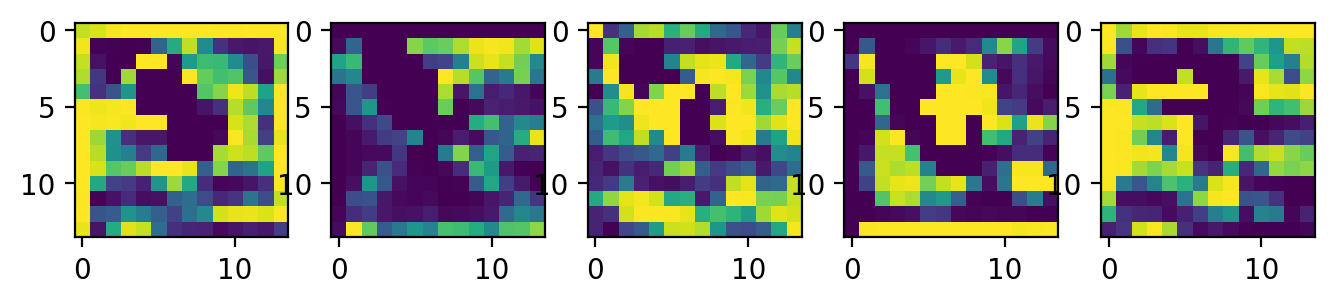

In [20]:
f, axarr = plt.subplots(1,5, figsize=(8,8), dpi= 200)

for i, mi in enumerate(M):
    axarr[i].imshow(mi.detach().numpy())

# Classifier

### Spatial Pooling


$P_i(X) =\sum_{j=1}^c([W∗X]_j·M_i)$

In [5]:
def part_based_features(feature_channels, M):
    """
    Pi(X) =c∑j=1([W∗X]j·Mi)
    """
    P = list()
    for mi in M:
        pi = sum(feature_channel @ mi for feature_channel in feature_channels)
        P.append(pi.unsqueeze(0))
    return torch.cat(P)

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)
        self.vgg19.classifier[0] = nn.Linear(in_features=980, out_features=4096, bias=True)
        self.vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=200, bias=True)
        
    def forward(self, P):
        x = P.view(1,980)
        x = self.vgg19.classifier(x)
        x = nn.Softmax(dim=0)(x)
        return x

In [33]:
classifier = Classifier()

In [34]:
save_classifier_model = 'models/classifier.pth'

$L(X) =∑_{i=1}^N[L_{cls}(Y^{(i)},Y^∗)] +L_{cng}(M_1, ...,M_N)$

In [ ]:
loss_clf = nn.CrossEntropyLoss()

In [ ]:
epochs = 10
optimizer = torch.optim.Adam(classifier.parameters(), lr = 0.01)
for epoch in range(epochs):
    for imgs, labels in trainloader:
        for i, img in enumerate(imgs):
            label = labels[i:i+1]
            img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
            img = img.unsqueeze(0)
            channels = vgg19.features(img)
            coordinates = list()
            for channel in channels.detach().numpy()[0]:
                coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]
            t_flat = [point for coordinate in coordinates for point in coordinate]
            t_flat = torch.FloatTensor(t_flat)
            M = list()
            for N in range(N_parts):      
                # Calculate weight vector "d"
                part = torch.load(f'models/part{N}.pth')
                d = part(t_flat)
                # Calculate attention map "M"
                mi = attention_map(channels[0], d)
                M.append(mi)

            l_cng = torch.tensor(loss_CNG(M, coordinates), requires_grad = True)
            P = part_based_features(channels[0], M)
    
            output = classifier(P)
        
         #   prediction = torch.argmax(output)
            loss = l_cng + loss_clf(output, label.long())
            
            for i, l in enumerate(l_cng):
                l.backward(retain_graph=True)
 
            optimizer.step()
            optimizer.zero_grad()
        
    print(loss,"\n")

In [35]:
...

tensor([ 249592.7500, 2355497.7500, 3536901.0000, 3946479.7500, 1077009.0000],
       grad_fn=<AddBackward0>) 

tensor([1883096.1250, 3041310.2500, 1002922.1875, 2370028.0000, 2152381.5000],
       grad_fn=<AddBackward0>) 

tensor([2883294.0000, 2832995.0000, 3093154.0000,  771162.6875, 2882391.2500],
       grad_fn=<AddBackward0>) 

tensor([3405203.2500,  898191.8750, 2930962.5000, 3873893.5000, 3087555.5000],
       grad_fn=<AddBackward0>) 

tensor([1973482.1250, 3222752.2500, 3789137.5000, 2974842.7500, 4509590.5000],
       grad_fn=<AddBackward0>) 

tensor([4138853.5000, 3936995.5000, 3482432.5000, 3329948.2500, 4459486.5000],
       grad_fn=<AddBackward0>) 

tensor([4537684.5000, 4031375.5000, 3587804.0000, 1828229.7500, 3153385.7500],
       grad_fn=<AddBackward0>) 

tensor([2025211.2500, 2427974.5000, 4709726.0000, 1319464.3750, 1514840.2500],
       grad_fn=<AddBackward0>) 

tensor([1950500.2500, 3634619.0000, 3181980.5000,  958434.6250, 2487726.0000],
       grad_fn=<AddBackwa

In [36]:
torch.save(classifier, save_classifier_model)

# Testing

In [37]:
cnn = torch.load('models/classifier.pth')

In [ ]:
img , label = trainset[120]

In [ ]:
for imgs, labels in testloader:
    for i, img in enumerate(imgs):
        label = labels[i:i+1]
        img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
        img = img.unsqueeze(0)
        channels = vgg19.features(img)
        coordinates = list()
        for channel in channels.detach().numpy()[0]:
            coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]
        t_flat = [point for coordinate in coordinates for point in coordinate]
        t_flat = torch.FloatTensor(t_flat)
        M = list()
        for N in range(N_parts):      
            # Calculate weight vector "d"
            part = torch.load(f'models/part{N}.pth')
            d = part(t_flat)
            # Calculate attention map "M"
            mi = attention_map(channels[0], d)
            M.append(mi)

        l_cng = torch.tensor(loss_CNG(M, coordinates), requires_grad = True)
        P = part_based_features(channels[0], M)

        output = cnn(P)

        loss = l_cng + loss_clf(output, label.long())

        prediction = 0
        index = 0
        for i, o in enumerate(output[0]):
            if o > prediction:
                prediction = o
                index = i

        print("Prediction:",index,"Ground truth:", label[0].item())

print(loss,"\n")


In [43]:
...

Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 2
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 2
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 2
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 2
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 1
Prediction